<div style="background:#0f172a;color:#f8fafc;padding:18px 22px;border-radius:12px;font-family:'Inter', Segoe UI, system-ui; line-height:1.6">
  <div style="font-size:18px; font-weight:700; text-decoration:underline; margin-bottom:10px">
    Abstract & Introduction — Deep Hedging sous Black–Scholes
  </div>

  <p>
    Ce projet met en place un cadre complet de <b>Deep Hedging</b> pour une option européenne
    dans un monde de type <b>Black–Scholes</b>. L’objectif est de comparer une stratégie de couverture
    classique, basée sur le <b>Delta théorique</b>, à une stratégie <b>apprise</b> via un réseau de neurones
    entraîné sur des trajectoires simulées.
  </p>

  <p>
    Dans le modèle de Black–Scholes, la couverture idéale repose sur une
    <b>réplication continue</b> sans coûts de transaction. En pratique, cette approche se heurte à :
  </p>

  <ul>
    <li>des <b>rebalancements discrets</b> plutôt que continus,</li>
    <li>des <b>coûts de transaction</b> sur le sous-jacent,</li>
    <li>des dynamiques de marché parfois <b>non linéaires</b>,</li>
    <li>la nécessité de maîtriser le <b>risque extrême</b> plutôt que la seule erreur moyenne.</li>
  </ul>

  <p>
    Le <b>Deep Hedging</b> permet de contourner ces limitations en apprenant directement une politique
    de couverture à partir de simulations Monte Carlo. Le réseau neuronal (MLP / LSTM) observe un état réduit
    — prix normalisé et temps jusqu’à maturité — et génère des décisions de couverture optimisées pour réduire
    un <b>risque de queue</b> mesuré par la <b>CVaR</b> (Conditional Value-at-Risk).
  </p>

  <p>
    Le notebook développe :
  </p>

  <ul>
    <li>un simulateur complet de trajectoires Black–Scholes,</li>
    <li>un environnement de Deep Hedging (PnL, frictions, coûts de trading),</li>
    <li>une fonction de perte basée sur la CVaR (Rockafellar & Uryasev),</li>
    <li>un modèle neuronal générant des ratios de couverture,</li>
    <li>une comparaison détaillée avec le <b>Delta Hedging</b> analytique,</li>
    <li>et une série de <b>stress tests</b> (σ, coûts, fréquence de hedging).</li>
  </ul>

  <p>
    L’objectif est de démontrer la compréhension complète de la théorie de la couverture
    sous Black–Scholes et d’illustrer comment les réseaux de neurones peuvent améliorer
    la gestion du risque dans un cadre réaliste.
  </p>
</div>


<div style="background:#0f172a;color:#f8fafc;padding:18px 22px;border-radius:12px;font-family:'Inter', Segoe UI, system-ui; line-height:1.6">
  <div style="font-size:18px; font-weight:700; text-decoration:underline; margin-bottom:10px">
    Bloc 0 — Imports généraux, device & dtype
  </div>

  <p>
    Ce bloc initialise l’environnement de travail pour le projet de <b>Deep Hedging</b> :
  </p>

  <ul>
    <li>Import des bibliothèques principales : <code>numpy</code>, <code>torch</code>, <code>matplotlib</code>, etc.</li>
    <li>Choix du <b>dtype de travail</b> (ici <code>torch.float32</code>) pour accélérer les calculs.</li>
    <li>Détection automatique du <b>device</b> : GPU (<code>cuda</code>), <code>mps</code> (Apple) ou CPU.</li>
  </ul>

  <p>
    L’objectif est d’avoir un environnement cohérent (même dtype, même device) pour toutes les
    simulations et l’entraînement du modèle de Deep Hedging.
  </p>
</div>


In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

DTYPE = torch.float32

# Détection device (cpu / cuda / mps)
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

print(f"DEVICE utilisé : {DEVICE}, dtype = {DTYPE}")


DEVICE utilisé : mps, dtype = torch.float32


<div style="background:#0f172a;color:#f8fafc;padding:18px 22px;border-radius:12px;font-family:'Inter', Segoe UI, system-ui; line-height:1.6">
  <div style="font-size:18px; font-weight:700; text-decoration:underline; margin-bottom:10px">
    Bloc 1 — Configuration globale du problème de Deep Hedging
  </div>

  <p>
    Ce bloc définit les configurations principales du problème via des <code>dataclass</code> :
  </p>

  <ul>
    <li><b>MarketConfig</b> : paramètres de marché type Black–Scholes (spot, taux, volatilité, maturité, nombre de dates de hedging) et caractéristiques de l’option (call, strike, coûts de transaction).</li>
    <li><b>TrainingConfig</b> : paramètres d’apprentissage (nombre d’epochs, batch size, <code>learning rate</code>, niveau de <code>CVaR</code>, fréquence d’affichage).</li>
    <li><b>DeepHedgingConfig</b> : configuration globale regroupant marché, entraînement, device et dtype.</li>
  </ul>

  <p>
    Une instance unique <code>cfg</code> est créée et utilisée dans tout le notebook pour garantir une
    centralisation et une cohérence des paramètres de simulation et de training.
  </p>
</div>


In [2]:
from dataclasses import dataclass

@dataclass
class MarketConfig:
    S0: float = 100.0
    r: float = 0.03
    q: float = 0.0
    sigma: float = 0.2   # volatilité diffusion

    # Paramètres Merton
    lambda_jump: float = 1.0      # intensité de Poisson (sauts/an)
    mu_J: float = -0.1            # moyenne du log-jump
    sigma_J: float = 0.3          # std du log-jump
    use_jumps: bool = True        # activer / désactiver les sauts

    T: float = 1.0
    n_steps: int = 52          # nombre de dates de hedging (52 => Rebalancing hebdomadaire)
    #n_steps: int = 252         # nombre de dates de hedging (252 => Rebalancing quotidien) (Trop lourd pour entrainer)
    #n_steps: int = 104          # nombre de dates de hedging (104 => Rebalancing bi-hebdomadaire)

    K: float = 100.0
    is_call: bool = True

    cost_s: float = 0.0002
    n_paths_train: int = 200_000
    n_paths_val: int = 50_000



@dataclass
class TrainingConfig:
    # Optimisation
    n_epochs: int = 50
    batch_size: int = 10_000
    lr: float = 1e-3
    
    # Utility CVaR
    cvar_alpha: float = 0.025
    
    # Monitoring
    print_every: int = 5

@dataclass
class RandomConfig:
    seed_global=1234,
    seed_train=1234,
    seed_val=1234,
    seed_eval_merton=1234,
    seed_eval_bs=1234,
    seed_eval_bs_merton=1234

@dataclass
class DeepHedgingConfig:
    market: MarketConfig = MarketConfig()
    training: TrainingConfig = TrainingConfig()
    device: torch.device = DEVICE
    dtype: torch.dtype = DTYPE
    random: RandomConfig = RandomConfig()


# Instance de config globale
cfg = DeepHedgingConfig()


<div style="background:#0f172a;color:#f8fafc;padding:18px 22px;border-radius:12px;font-family:'Inter', Segoe UI, system-ui; line-height:1.6">
  <div style="font-size:18px; font-weight:700; text-decoration:underline; margin-bottom:10px">
    Bloc 2 — Monde Black–Scholes simplifié (SimpleWorldBS)
  </div>

  <p>
    Ce bloc implémente une version simplifiée du monde <b>SimpleWorld_Spot_ATM</b> du repo deephedging :
  </p>

  <ul>
    <li>Simulation du sous-jacent selon un <b>processus log-normal Black–Scholes</b> sous la mesure risque-neutre.</li>
    <li>Construction des trajectoires <code>S</code>, des incréments <code>dS</code> et du payoff terminal de l’option (call ou put).</li>
    <li>Retour des données sous forme d’un dictionnaire proche de la structure <code>tf_data</code> : <code>{"S", "dS", "payoff", "t_grid"}</code>.</li>
  </ul>

  <p>
    Ce monde sert de base de données simulée pour entraîner et évaluer le modèle de Deep Hedging
    dans un cadre Black–Scholes standard.
  </p>
</div>


In [3]:
class SimpleWorldBS:
    """
    Ici on a un monde simple avec :
    - un sous-jacent BS
    - une option européenne (call ou put)
    - des coûts de transaction sur le spot
    """

    def __init__(self, mcfg: MarketConfig, device=DEVICE, dtype=DTYPE):
        self.cfg = mcfg
        self.device = device
        self.dtype = dtype
        
        # Pré-calcul du time grid
        self.dt = mcfg.T / mcfg.n_steps
        self.t_grid = np.linspace(0, mcfg.T, mcfg.n_steps + 1)

    def simulate_paths(self, n_paths: int, seed: int = 1234):
        """
        Simule des trajectoires BS pour le spot :
            dS_t = S_t * ( (r - q) dt + sigma sqrt(dt) * Z )
            
        Retourne un dict numpy, proche de world.tf_data dans deephedging :
            {
                "S": (n_paths, n_steps+1),
                "dS": (n_paths, n_steps),
                "payoff": (n_paths,),
            }
        """
        rng = np.random.default_rng(seed)
        m = self.cfg
        dt = self.dt
        
        # Bruits gaussiens
        Z = rng.standard_normal(size=(n_paths, m.n_steps))
        
        S = np.zeros((n_paths, m.n_steps + 1), dtype=np.float32)
        S[:, 0] = m.S0
        
        drift = (m.r - m.q - 0.5 * m.sigma**2) * dt
        vol   = m.sigma * math.sqrt(dt)
        
        for t in range(m.n_steps):
            S[:, t+1] = S[:, t] * np.exp(drift + vol * Z[:, t])
        
        # dS_t = S_{t+1} - S_t
        dS = S[:, 1:] - S[:, :-1]
        
        # Payoff
        if m.is_call:
            payoff = np.maximum(S[:, -1] - m.K, 0.0)
        else:
            payoff = np.maximum(m.K - S[:, -1], 0.0)
        
        return {
            "S": S,
            "dS": dS,
            "payoff": payoff,
            "t_grid": self.t_grid,
        }

# Exemple rapide
world_train = SimpleWorldBS(cfg.market)
data_test = world_train.simulate_paths(100_000)
print("Shapes :", data_test["S"].shape, data_test["dS"].shape, data_test["payoff"].shape)


Shapes : (100000, 53) (100000, 52) (100000,)


In [4]:
class SimpleWorldMerton:
    """
    Monde Merton (jump-diffusion) compatible avec ton Deep Hedging.

    dS_t / S_{t-} = (r - q - λ κ) dt + σ dW_t + dJ_t,
    avec J_t = ∑ (e^{Y_i} - 1), Y_i ~ N(mu_J, sigma_J^2).

    On renvoie un dict avec:
        "S": (n_paths, n_steps+1)
        "dS": (n_paths, n_steps)
        "payoff": (n_paths,)
        "t_grid": (n_steps+1,)
    """

    def __init__(self, mcfg: MarketConfig, device=DEVICE, dtype=DTYPE):
        self.cfg = mcfg
        self.device = device
        self.dtype = dtype

        self.dt = mcfg.T / mcfg.n_steps
        self.t_grid = np.linspace(0, mcfg.T, mcfg.n_steps + 1)

        # Pré-calcul pour drift risque-neutre
        self.kappa = math.exp(mcfg.mu_J + 0.5 * mcfg.sigma_J**2) - 1.0
        self.drift = (
            mcfg.r - mcfg.q - mcfg.lambda_jump * self.kappa
            - 0.5 * mcfg.sigma**2
        )

    def simulate_paths(self, n_paths: int, seed: int = 1234):
        rng = np.random.default_rng(seed)
        m = self.cfg
        dt = self.dt

        S = np.zeros((n_paths, m.n_steps + 1), dtype=np.float64)
        S[:, 0] = m.S0

        vol = m.sigma * math.sqrt(dt)

        for t in range(m.n_steps):
            # Diffusion Brownienne
            Z = rng.standard_normal(size=n_paths)

            # Sauts de Poisson
            N_jump = rng.poisson(m.lambda_jump * dt, size=n_paths)
            has_jump = N_jump > 0

            # Log-sauts si N_t > 0
            logJ = np.zeros(n_paths, dtype=np.float64)
            if np.any(has_jump):
                # Nombre total de sauts sur le pas
                n_tot = N_jump[has_jump].sum()
                Y = rng.normal(
                    loc=m.mu_J,
                    scale=m.sigma_J,
                    size=n_tot
                )

                # On reconstruit la somme des log-sauts pour chaque chemin
                idx = np.cumsum(np.concatenate([[0], N_jump[has_jump]]))
                for k in range(len(idx) - 1):
                    a, b = idx[k], idx[k+1]
                    logJ[np.where(has_jump)[0][k]] = Y[a:b].sum()


            # Incrément log(S)
            dlogS = self.drift * dt + vol * Z + logJ
            S[:, t+1] = S[:, t] * np.exp(dlogS)

        dS = S[:, 1:] - S[:, :-1]

        if m.is_call:
            payoff = np.maximum(S[:, -1] - m.K, 0.0)
        else:
            payoff = np.maximum(m.K - S[:, -1], 0.0)

        return {
            "S": S,
            "dS": dS,
            "payoff": payoff,
            "t_grid": self.t_grid,
        }


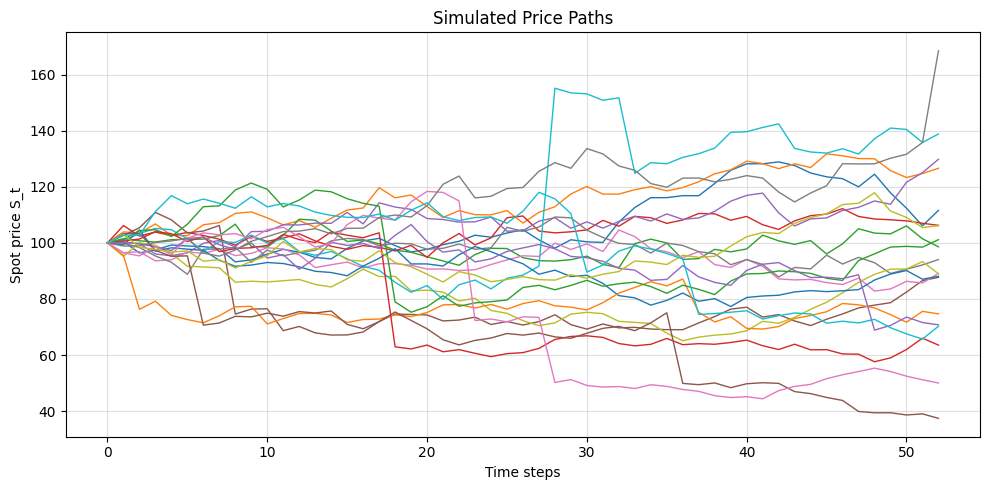

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_simulated_paths(S, n_paths_to_plot=20):
    """
    Affiche un sous-échantillon de trajectoires simulées.
    
    Paramètres
    ----------
    S : array (n_paths, n_steps+1)
        Trajectoires simulées du sous-jacent.
    n_paths_to_plot : int
        Nombre de chemins à tracer (par défaut 20).
    """
    n_paths, T_plus_1 = S.shape
    t = np.arange(T_plus_1)

    # On sélectionne quelques trajectoires (sans surcharge visuelle)
    idx = np.random.choice(n_paths, size=min(n_paths_to_plot, n_paths), replace=False)

    plt.figure(figsize=(10, 5))
    for i in idx:
        plt.plot(t, S[i], linewidth=1)

    plt.xlabel("Time steps")
    plt.ylabel("Spot price S_t")
    plt.title("Simulated Price Paths")
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.show()

# Exemple pour tester
world = SimpleWorldMerton(cfg.market)     # ou SimpleWorldBS si pas de sauts
data = world.simulate_paths(200)          # 200 trajectoires
plot_simulated_paths(data["S"], n_paths_to_plot=20)



<div style="background:#0f172a;color:#f8fafc;padding:18px 22px;border-radius:12px;font-family:'Inter', Segoe UI, system-ui; line-height:1.6">
  <div style="font-size:18px; font-weight:700; text-decoration:underline; margin-bottom:10px">
    Bloc 3 — Fonctions statistiques de base (moyenne, variance, CVaR)
  </div>

  <p>
    Ce bloc regroupe des utilitaires statistiques en PyTorch, inspirés des fonctions de base du repo deephedging :
  </p>

  <ul>
    <li><code>weighted_mean</code> : moyenne pondérée d’un échantillon.</li>
    <li><code>weighted_var</code> / <code>weighted_std</code> : variance et écart-type pondérés.</li>
    <li><code>cvar_from_samples</code> : <b>CVaR empirique</b> sur un vecteur de PnL (en regardant la queue gauche).</li>
  </ul>

  <p>
    Ces outils servent à quantifier le risque extrême et peuvent être réutilisés dans la définition
    des fonctions d’utilité et des métriques de performance des stratégies de couverture.
  </p>
</div>


In [6]:
def weighted_mean(x: torch.Tensor, w: torch.Tensor = None) -> torch.Tensor:
    """
    Moyenne pondérée : sum(w*x)/sum(w).
    Si w est None, simple moyenne.
    """
    if w is None:
        return x.mean()
    w = w / w.sum()
    return (w * x).sum()

def weighted_var(x: torch.Tensor, w: torch.Tensor = None) -> torch.Tensor:
    """
    Variance pondérée.
    """
    m = weighted_mean(x, w)
    if w is None:
        return ((x - m) ** 2).mean()
    w = w / w.sum()
    return (w * (x - m) ** 2).sum()

def weighted_std(x: torch.Tensor, w: torch.Tensor = None) -> torch.Tensor:
    """
    Écart-type pondéré.
    """
    return torch.sqrt(weighted_var(x, w))

def cvar_from_samples(x: torch.Tensor, alpha: float = 0.05) -> torch.Tensor:
    """
    CVaR empirique au niveau alpha sur un vecteur de PnL.
    
    Convention : on suppose que x = -perte = gains.
    On regarde les pires valeurs (queue gauche).
    """
    # Tri croissant (les valeurs les plus petites = pires)
    sorted_x, _ = torch.sort(x)
    n = len(sorted_x)
    k = max(1, int(alpha * n))
    tail = sorted_x[:k]   # pires k valeurs
    return tail.mean()


<div style="background:#0f172a;color:#f8fafc;padding:18px 22px;border-radius:12px;font-family:'Inter', Segoe UI, system-ui; line-height:1.6">
  <div style="font-size:18px; font-weight:700; text-decoration:underline; margin-bottom:10px">
    Bloc 4 — Fonctions de risque type MonetaryUtility
  </div>

  <p>
    Ce bloc définit une classe <b>MonetaryUtility</b> simplifiée, inspirée du repo deephedging,
    pour mesurer la qualité d’un PnL ou de gains :
  </p>

  <ul>
    <li><b>Entropic</b> utility : <code>U(X) = -1/λ · log E[exp(-λX)]</code>.</li>
    <li><b>CVaR</b> utility : utilisation directe de la CVaR empirique comme critère de risque.</li>
    <li><b>Expectation</b> : moyenne simple des gains.</li>
  </ul>

  <p>
    La méthode <code>loss(x)</code> renvoie la quantité à minimiser (<code>-U(X)</code>), ce qui permet
    d’intégrer facilement cette utilité comme <b>loss de training</b> dans le cadre du Deep Hedging.
  </p>
</div>


In [7]:
class MonetaryUtility:
    """
    Version simplifiée du MonetaryUtility du repo deephedging.
    Ici on implémente :
    - entropic
    - cvar (OCE-like simplifié)
    - expectation (moyenne simple)
    """
    
    def __init__(self, kind: str = "cvar", lmbda: float = 1.0, alpha: float = 0.05):
        self.kind = kind.lower()
        self.lmbda = lmbda
        self.alpha = alpha
    
    def __repr__(self):
        return f"MonetaryUtility(kind={self.kind}, lambda={self.lmbda}, alpha={self.alpha})"
    
    def utility(self, x: torch.Tensor) -> torch.Tensor:
        """
        Renvoie U(X) (scalaire).
        """
        if self.kind == "exp" or self.kind == "entropic":
            # U(X) = -1/λ log E[exp(-λX)]
            lmbda = self.lmbda
            return - (1.0 / lmbda) * torch.log(torch.mean(torch.exp(-lmbda * x)))
        
        elif self.kind == "cvar":
            # Ici : on simplifie en prenant directement la CVaR empirique comme "utility"
            # si X = gains (positif = bon), on préfère les "pire cas" les moins mauvais.
            return cvar_from_samples(x, alpha=self.alpha)
        
        elif self.kind == "mean":
            return x.mean()
        
        else:
            raise ValueError(f"Unknown utility kind: {self.kind}")
    
    def loss(self, x: torch.Tensor) -> torch.Tensor:
        """
        Loss à MINIMISER = -U(X).
        Si on maximise l'utilité, on minimise cette loss.
        """
        return -self.utility(x)
    

# Exemple rapide
util_cvar = MonetaryUtility(kind="cvar", alpha=0.05)
util_ent  = MonetaryUtility(kind="entropic", lmbda=1.0)

x_test = torch.randn(1000)
print("CVaR utility :", util_cvar.utility(x_test).item())
print("Entropic utility :", util_ent.utility(x_test).item())


CVaR utility : -2.0325064659118652
Entropic utility : -0.46217378973960876


<div style="background:#0f172a;color:#f8fafc;padding:18px 22px;border-radius:12px;font-family:'Inter', Segoe UI, system-ui; line-height:1.6">
  <div style="font-size:18px; font-weight:700; text-decoration:underline; margin-bottom:10px">
    Bloc 5 — Environnement Deep Hedging (DeepHedgingEnv)
  </div>

  <p>
    Ce bloc implémente un environnement <b>DeepHedgingEnv</b> en PyTorch, analogue au gym du repo deephedging :
  </p>

  <ul>
    <li>Construction des <b>features d’état</b> pour la politique : spot relatif (<code>S_t / S₀</code>) et temps normalisé.</li>
    <li>Exécution d’un <b>rollout</b> de stratégie à partir d’une policy <code>π</code> qui renvoie des variations de position <code>Δposition_t</code>.</li>
    <li>Calcul :
      <ul>
        <li>du PnL de trading : <code>∑ δ_t · dS_t</code>,</li>
        <li>des <b>coûts de transaction</b>,</li>
        <li>et des <b>gains finaux</b> : <code>gains = payoff − cost + pnl</code>.</li>
      </ul>
    </li>
  </ul>

  <p>
    Cet environnement est le cœur du projet : il permet de simuler l’impact de toute policy (MLP, LSTM, Delta analytique)
    dans un cadre homogène pour comparer les stratégies de couverture.
  </p>
</div>


In [8]:
class DeepHedgingEnv:
    """
    Version PyTorch simplifiée de VanillaDeepHedgingGym du repo deephedging.

    Hypothèses :
    - On ne hedge que le spot.
    - La politique renvoie Δposition (actions), que l'on cumule en delta_t.
    - PnL = sum_t delta_t * dS_t
    - Cost = sum_t cost_s * |Δposition_t| * S_t (coût proportionnel)
    - Gains = payoff - Cost + PnL
    """

    def __init__(self, cfg: DeepHedgingConfig):
        self.cfg = cfg
        self.mcfg = cfg.market
        self.device = cfg.device
        self.dtype = cfg.dtype

    def build_state_features(self, S_batch: torch.Tensor) -> torch.Tensor:
        """
        Construction des features d'état pour la politique.
        Ici on fait simple, comme dans ton projet :
        - S_rel = S_t / S_0
        - time_feat = t / T

        Entrée :
            S_batch : (B, T+1)
        Sortie :
            X : (B, T, d_in=2)
        """
        B, T_plus_1 = S_batch.shape
        T = T_plus_1 - 1

        # Spot relatif
        S_rel = S_batch[:, :-1] / S_batch[:, [0]]

        # Time feature (fraction du temps écoulé)
        t_grid = torch.linspace(
            0, 1.0, T,
            device=S_batch.device,
            dtype=S_batch.dtype
        )
        time_feat = t_grid.unsqueeze(0).expand(B, -1)

        X = torch.stack([S_rel, time_feat], dim=-1)  # (B, T, 2)
        return X

    def rollout(self, policy: nn.Module, S: torch.Tensor, payoff: torch.Tensor):
        """
        Exécute la stratégie de hedging sur un batch donné.

        Entrées :
            S      : (B, T+1) trajectoires spot (déjà sur device)
            payoff : (B,) payoff terminal (déjà sur device)

        Sorties : dict avec :
            actions : (B, T)
            deltas  : (B, T)
            pnl     : (B,)
            cost    : (B,)
            gains   : (B,)
        """
        cfg = self.cfg
        mcfg = self.mcfg

        # On suppose que S et payoff sont déjà sur cfg.device et au bon dtype
        # (c'est le cas si on les a créés via generate_datasets(cfg)).
        B, T_plus_1 = S.shape
        T = T_plus_1 - 1

        # Features X = (B, T, 2)
        X = self.build_state_features(S)

        # Appel à la policy — elle est déjà sur le bon device
        # Hypothèse : policy(X) -> (B, T) = Δpositions
        delta_actions = policy(X)  # (B, T)

        if delta_actions.shape != (B, T):
            raise ValueError(
                f"policy(X) doit renvoyer shape (B, T), obtenu {delta_actions.shape}"
            )

        # Position delta_t = cumul des Δpositions
        deltas = torch.cumsum(delta_actions, dim=1)  # (B, T)

        # dS_t = S_{t+1} - S_t
        dS = S[:, 1:] - S[:, :-1]  # (B, T)

        # PnL de trading : sum_t delta_t * dS_t
        pnl = torch.sum(deltas * dS, dim=1)  # (B,)

        # Coût de transaction : sum_t cost_s * |Δposition_t| * S_t
        cost_s = torch.tensor(mcfg.cost_s, device=S.device, dtype=S.dtype)
        S_mid = S[:, :-1]  # spot au moment de l'action

        cost = torch.sum(cost_s * torch.abs(delta_actions) * S_mid, dim=1)  # (B,)

        # Gains totaux
        gains = payoff - cost + pnl

        return {
            "actions": delta_actions,
            "deltas": deltas,
            "pnl": pnl,
            "cost": cost,
            "gains": gains,
            "payoff": payoff,
        }

<div style="background:#0f172a;color:#f8fafc;padding:18px 22px;border-radius:12px;font-family:'Inter', Segoe UI, system-ui; line-height:1.6">
  <div style="font-size:18px; font-weight:700; text-decoration:underline; margin-bottom:10px">
    Bloc 6 — Policy MLP (réseau de couverture simple)
  </div>

  <p>
    Ce bloc définit une première policy neuronale <b>PolicyMLP</b> utilisée pour le Deep Hedging :
  </p>

  <ul>
    <li>Entrée : séquence de features <code>X</code> de taille <code>(B, T, d_in)</code>.</li>
    <li>Architecture : MLP appliqué sur chaque pas de temps (après reshaping), avec plusieurs couches cachées.</li>
    <li>Sortie : matrice <code>(B, T)</code> de <b>Δpositions</b>, c’est-à-dire les variations de delta à chaque date.</li>
  </ul>

  <p>
    Cette policy sert de baseline neuronale, plus simple qu’un LSTM, pour tester l’apprentissage
    d’une stratégie de couverture optimisée en termes de CVaR.
  </p>
</div>


In [9]:
class PolicyMLP(nn.Module):
    """
    Policy simple de type MLP (non récurrente) :
    - Entrée : (B, T, d_in)
    - Sortie : (B, T) = Δpositions_t
    """
    def __init__(self, d_in=2, d_hidden=32, depth=3, dropout=0.0):
        super().__init__()
        
        layers = []
        d = d_in
        for _ in range(depth):
            layers.append(nn.Linear(d, d_hidden))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            d = d_hidden
        # Dernière couche : scalaire (Δposition_t)
        layers.append(nn.Linear(d_hidden, 1))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, X):
        """
        X : (B, T, d_in)
        Sortie : (B, T)
        """
        B, T, d_in = X.shape
        X_flat = X.reshape(B*T, d_in)   # (B*T, d_in)
        out = self.net(X_flat)          # (B*T, 1)
        out = out.view(B, T)            # (B, T)
        return out


<div style="background:#0f172a;color:#f8fafc;padding:18px 22px;border-radius:12px;font-family:'Inter', Segoe UI, system-ui; line-height:1.6">
  <div style="font-size:18px; font-weight:700; text-decoration:underline; margin-bottom:10px">
    Bloc 6bis — Policy Delta Black–Scholes analytique
  </div>

  <p>
    Ce bloc implémente une policy analytique <b>DeltaBSPolicy</b> qui reproduit le
    <b>Delta Black–Scholes</b> dans le même formalisme que l’environnement Deep Hedging :
  </p>

  <ul>
    <li>Reconstruction du spot <code>S_t</code> à partir des features <code>(S_rel, time_feat)</code>.</li>
    <li>Calcul du Delta théorique pour un call/put européen sous Black–Scholes.</li>
    <li>Conversion du Delta absolu <code>δ_t</code> en <code>Δposition_t = δ_t − δ_{t−1}</code> pour être compatible avec l’environnement.</li>
  </ul>

  <p>
    Cette policy offre une <b>référence analytique</b> directement comparable au Deep Hedging,
    dans le même environnement et avec la même définition du PnL et des coûts.
  </p>
</div>


In [10]:
class DeltaBSPolicy(nn.Module):
    """
    Policy analytique qui implémente le Delta Black–Scholes.
    Compatible avec DeepHedgingEnv.rollout :
    - Entrée : X = (B, T, 2) avec [S_rel, time_feat]
    - Sortie : (B, T) = Δposition_t (variation de delta à chaque pas)
    """
    def __init__(self, market_cfg: MarketConfig, device=DEVICE, dtype=DTYPE):
        super().__init__()
        self.mcfg = market_cfg
        self.device = device
        self.dtype = dtype

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        X : (B, T, 2) = [S_rel, time_feat]
        Retour :
            delta_actions : (B, T) = Δposition_t
        """
        m = self.mcfg
        X = X.to(self.device, dtype=self.dtype)
        B, T, d_in = X.shape
        assert d_in == 2, f"On attend 2 features (S_rel, time), reçu d_in={d_in}"

        S_rel = X[..., 0]       # (B, T), S_t / S0
        time_feat = X[..., 1]   # (B, T), dans [0,1] ≈ t/T

        # Reconstruire S_t
        S_t = S_rel * m.S0      # (B, T)

        # Temps restant jusqu'à maturité (en années)
        # time_feat ≈ t / T ⇒ t ≈ time_feat * T ⇒ T_rem = T - t
        T_rem = m.T * (1.0 - time_feat)   # (B, T)
        T_rem = torch.clamp(T_rem, min=1e-6)

        # Calcul du Delta BS (call ou put)
        delta_t = self._bs_delta_torch(S_t, m.K, T_rem, m.r, m.q, m.sigma, m.is_call)

        # On convertit Delta absolu delta_t en Δposition_t = delta_t - delta_{t-1}
        delta_prev = torch.zeros_like(delta_t)
        delta_prev[:, 1:] = delta_t[:, :-1]
        delta_actions = delta_t - delta_prev  # (B, T)

        return delta_actions

    @staticmethod
    def _bs_delta_torch(S: torch.Tensor,
                        K: float,
                        T: torch.Tensor,
                        r: float,
                        q: float,
                        sigma: float,
                        is_call: bool = True) -> torch.Tensor:
        """
        Delta Black–Scholes en PyTorch pour call/put européen.
        S, T sont des tensors broadcastables.
        """
        eps = 1e-8
        S = torch.clamp(S, min=eps)
        T = torch.clamp(T, min=eps)

        r_t = torch.tensor(r, dtype=S.dtype, device=S.device)
        q_t = torch.tensor(q, dtype=S.dtype, device=S.device)
        sigma_t = torch.tensor(sigma, dtype=S.dtype, device=S.device)
        K_t = torch.tensor(K, dtype=S.dtype, device=S.device)

        d1 = (torch.log(S / K_t) + (r_t - q_t + 0.5 * sigma_t**2) * T) / (sigma_t * torch.sqrt(T))
        Nd1 = 0.5 * (1.0 + torch.erf(d1 / math.sqrt(2.0)))
        disc_q = torch.exp(-q_t * T)

        if is_call:
            delta = disc_q * Nd1
        else:
            delta = disc_q * (Nd1 - 1.0)

        return delta


<div style="background:#0f172a;color:#f8fafc;padding:18px 22px;border-radius:12px;font-family:'Inter', Segoe UI, system-ui; line-height:1.6">
  <div style="font-size:18px; font-weight:700; text-decoration:underline; margin-bottom:10px">
    Bloc 7 — Génération des datasets d’entraînement et de validation
  </div>

  <p>
    Ce bloc prépare les données nécessaires à l’entraînement du modèle de Deep Hedging :
  </p>

  <ul>
    <li>Simulation d’un large jeu de trajectoires <b>train</b> (spots et payoffs) avec un seed donné.</li>
    <li>Simulation d’un jeu de trajectoires <b>validation</b> distinct (nouveau seed) pour évaluer la généralisation.</li>
    <li>Conversion des sorties <code>numpy</code> en <code>torch.Tensor</code> sur le <b>device</b> et <b>dtype</b> définis dans la config.</li>
  </ul>

  <p>
    Le résultat est un couple <code>(S_train, payoff_train)</code> et <code>(S_val, payoff_val)</code>
    utilisable directement dans la boucle d’entraînement.
  </p>
</div>


In [11]:
def generate_datasets(cfg: DeepHedgingConfig):
    if cfg.market.use_jumps:
        world = SimpleWorldMerton(cfg.market)
    else:
        world = SimpleWorldBS(cfg.market)

    data_train = world.simulate_paths(cfg.market.n_paths_train,
                                      seed=cfg.random.seed_train)
    S_train = torch.tensor(data_train["S"], dtype=cfg.dtype, device=cfg.device)
    payoff_train = torch.tensor(data_train["payoff"], dtype=cfg.dtype, device=cfg.device)

    data_val = world.simulate_paths(cfg.market.n_paths_val,
                                    seed=cfg.random.seed_val)
    S_val = torch.tensor(data_val["S"], dtype=cfg.dtype, device=cfg.device)
    payoff_val = torch.tensor(data_val["payoff"], dtype=cfg.dtype, device=cfg.device)

    return (S_train, payoff_train), (S_val, payoff_val), world



# Test rapide
(train_data, val_data, world_obj) = generate_datasets(cfg)
S_train, payoff_train = train_data
print("Train S shape :", S_train.shape)
print("Train payoff shape :", payoff_train.shape)


Train S shape : torch.Size([200000, 53])
Train payoff shape : torch.Size([200000])


<div style="background:#0f172a;color:#f8fafc;padding:18px 22px;border-radius:12px;font-family:'Inter', Segoe UI, system-ui; line-height:1.6">
  <div style="font-size:18px; font-weight:700; text-decoration:underline; margin-bottom:10px">
    Bloc 8 — Loss Deep Hedging basée sur l’utilité des gains
  </div>

  <p>
    Ce bloc définit la fonction de perte utilisée pour entraîner le modèle :
  </p>

  <ul>
    <li>Exécution d’un <b>rollout</b> via <code>DeepHedgingEnv</code> pour obtenir les <code>gains</code> et les <code>actions</code>.</li>
    <li>Calcul d’une <b>loss principale</b> à partir d’une <b>MonetaryUtility</b> (par exemple CVaR des gains).</li>
    <li>Ajout d’une <b>régularisation</b> sur la taille des actions (pénalisation L2 des <code>Δpositions</code>).</li>
  </ul>

  <p>
    La loss finale combine ainsi la réduction du risque extrême (<b>CVaR</b>) et la maîtrise
    de l’agressivité de la stratégie de trading (via la régularisation).
  </p>
</div>


In [12]:
def deep_hedging_loss_batch(policy: nn.Module,
                            env: DeepHedgingEnv,
                            S_batch: torch.Tensor,
                            payoff_batch: torch.Tensor,
                            utility: MonetaryUtility) -> torch.Tensor:
    out = env.rollout(policy, S_batch, payoff_batch)
    gains = out["gains"]      # (B,)
    actions = out["actions"]  # (B, T)

    base_loss = utility.loss(gains)

    # Régularisation sur la taille des actions
    lambda_pos = 1e-4
    reg_pos = (actions**2).mean()

    return base_loss + lambda_pos * reg_pos



<div style="background:#0f172a;color:#f8fafc;padding:18px 22px;border-radius:12px;font-family:'Inter', Segoe UI, system-ui; line-height:1.6">
  <div style="font-size:18px; font-weight:700; text-decoration:underline; margin-bottom:10px">
    Bloc 9 — Boucle d’entraînement du modèle de Deep Hedging
  </div>

  <p>
    Ce bloc met en œuvre l’algorithme de training du modèle de Deep Hedging :
  </p>

  <ul>
    <li>Création des datasets train/val à partir du monde Black–Scholes.</li>
    <li>Initialisation de l’environnement et de l’optimiseur (<code>Adam</code>).</li>
    <li>Boucle sur les epochs avec :
      <ul>
        <li>mini-batchs aléatoires sur les chemins d’entraînement,</li>
        <li>rétropropagation de la loss Deep Hedging (basée sur l’utilité / CVaR),</li>
        <li>évaluation périodique sur le set de validation.</li>
      </ul>
    </li>
  </ul>

  <p>
    Les pertes train/val sont stockées dans un <code>history</code> pour analyse ultérieure
    (diagnostic d’overfitting / underfitting et qualité de la convergence).
  </p>
</div>


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import copy

def train_deep_hedging(
    cfg: DeepHedgingConfig,
    policy: nn.Module,
    utility: MonetaryUtility = None,
    patience: int = 5,
    min_delta: float = 1e-3,
):
    """
    Entraîne la policy de Deep Hedging avec :
    - DataLoader (batching propre)
    - Early stopping basé sur la loss de validation.

    Arguments :
    ----------
    patience : int
        Nombre d'epochs consécutives sans amélioration de la val_loss
        avant arrêt anticipé.
    min_delta : float
        Amélioration minimale de la val_loss pour être considérée
        comme significative.
    """
    if utility is None:
        utility = MonetaryUtility(kind="cvar", alpha=cfg.training.cvar_alpha)

    # ========================================================
    # 1) Génération des datasets
    # ========================================================
    (S_train, payoff_train), (S_val, payoff_val), world = generate_datasets(cfg)

    env = DeepHedgingEnv(cfg)
    policy = policy.to(cfg.device)

    optimizer = optim.Adam(policy.parameters(), lr=cfg.training.lr)
    n_epochs   = cfg.training.n_epochs
    batch_size = cfg.training.batch_size

    # Dataset / DataLoader pour le train
    train_dataset = TensorDataset(S_train, payoff_train)
    train_loader  = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=False,
    )

    history = {
        "train_loss": [],
        "val_loss":   [],
    }

    # --- Early stopping tracking ---
    best_val_loss     = float("inf")
    best_state_dict   = None
    epochs_no_improve = 0

    # ========================================================
    # 2) Boucle d'entraînement
    # ========================================================
    for epoch in range(1, n_epochs + 1):
        policy.train()
        losses_epoch = []

        # ----- Boucle sur les mini-batchs -----
        for S_batch, payoff_batch in train_loader:
            # S_batch, payoff_batch sont déjà sur cfg.device
            loss = deep_hedging_loss_batch(policy, env, S_batch, payoff_batch, utility)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses_epoch.append(loss.detach().item())

        train_loss = float(np.mean(losses_epoch))

        # ----- Validation complète -----
        policy.eval()
        with torch.no_grad():
            val_loss = deep_hedging_loss_batch(policy, env, S_val, payoff_val, utility).item()

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        # ----- Early stopping update -----
        if val_loss + min_delta < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_state_dict = copy.deepcopy(policy.state_dict())
        else:
            epochs_no_improve += 1

        # ----- Monitoring -----
        if (epoch % cfg.training.print_every == 0) or (epoch == 1) or (epoch == n_epochs):
            print(
                f"[Epoch {epoch}/{n_epochs}] "
                f"train_loss={train_loss:.4f} | val_loss={val_loss:.4f} "
                f"| no_improve={epochs_no_improve}/{patience}"
            )

        # ----- Condition d'arrêt anticipé -----
        if epochs_no_improve >= patience:
            print(
                f"Early stopping déclenché à l'epoch {epoch} "
                f"(meilleure val_loss = {best_val_loss:.4f})"
            )
            break

    # ========================================================
    # 3) Rechargement des meilleurs poids
    # ========================================================
    if best_state_dict is not None:
        policy.load_state_dict(best_state_dict)

    return {
        "policy":     policy,
        "history":    history,
        "world":      world,
        "train_data": (S_train, payoff_train),
        "val_data":   (S_val, payoff_val),
        "utility":    utility,
    }

# Exemple rapide avec une petite policy MLP
policy_test = PolicyMLP(d_in=2, d_hidden=32, depth=2, dropout=0.1)
res_train = train_deep_hedging(cfg, policy_test)

[Epoch 1/50] train_loss=59.3954 | val_loss=14.3118 | no_improve=0/5
[Epoch 5/50] train_loss=1.4749 | val_loss=0.3387 | no_improve=0/5


<div style="background:#0f172a;color:#f8fafc;padding:18px 22px;border-radius:12px;font-family:'Inter', Segoe UI, system-ui; line-height:1.6">
  <div style="font-size:18px; font-weight:700; text-decoration:underline; margin-bottom:10px">
    Bloc 10 — Delta BS & évaluation cohérente des stratégies
  </div>

  <p>
    Ce bloc sert à <b>comparer</b> de manière homogène la stratégie de Deep Hedging et la stratégie Delta analytique :
  </p>

  <ul>
    <li>Implémentation du Delta Black–Scholes standard (version numpy) pour un call européen.</li>
    <li>Fonction <code>evaluate_strategies_env</code> qui :
      <ul>
        <li>simule un nouveau jeu de trajectoires de test,</li>
        <li>évalue la policy Deep Hedging dans <code>DeepHedgingEnv</code>,</li>
        <li>évalue la policy Delta Black–Scholes dans le même environnement,</li>
        <li>calcule les gains, PnL, coûts et mesures de risque (CVaR, écart-type) pour les deux.</li>
      </ul>
    </li>
  </ul>

  <p>
    Le résultat permet de répondre à la question clé : <b>le Deep Hedging améliore-t-il la
    distribution de PnL (en particulier la queue gauche) par rapport à la couverture Delta classique ?</b>
  </p>
</div>


CVaR deep   : -0.7033399939537048
CVaR delta  : -43.381385803222656
Std deep    : 12.726837158203125
Std delta   : 55.60103225708008


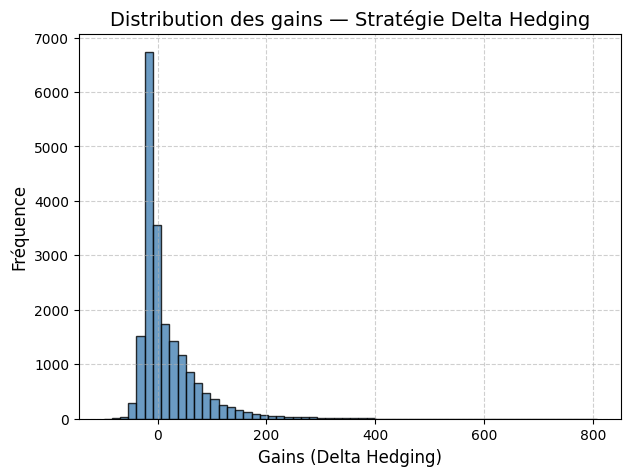

In [ ]:
from math import log, sqrt
from scipy.stats import norm

def bs_delta_call(S, K, T, r, q, sigma):
    """
    Delta BS d'un call européen.
    S, T peuvent être numpy arrays.
    """
    S = np.asarray(S, dtype=float)
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)


def evaluate_strategies_env(cfg: DeepHedgingConfig,
                            policy_trained: nn.Module,
                            n_paths_eval: int = 20_000):
    
    """
    Compare :
    - stratégie Deep Hedging (policy_trained)
    - stratégie Delta Black–Scholes analytique (DeltaBSPolicy)
    
    Les deux sont évaluées dans le même DeepHedgingEnv,
    avec la même définition des gains :
        gains = payoff - cost + pnl
    """

    # 1) Génération d'un dataset de test
    world = SimpleWorldMerton(cfg.market)
    data = world.simulate_paths(n_paths_eval, seed=cfg.random.seed_eval_merton)
    S_np = data["S"]          # (N, T+1)
    payoff_np = data["payoff"]  # (N,)

    # Conversion en torch
    S = torch.tensor(S_np, dtype=cfg.dtype, device=cfg.device)
    payoff = torch.tensor(payoff_np, dtype=cfg.dtype, device=cfg.device)

    # 2) Environnement
    env = DeepHedgingEnv(cfg)

    # 3) Deep Hedging policy
    policy_trained = policy_trained.to(cfg.device)
    policy_trained.eval()
    with torch.no_grad():
        out_deep = env.rollout(policy_trained, S, payoff)
    gains_deep = out_deep["gains"].detach().cpu()  # (N,)
    pnl_deep   = out_deep["pnl"].detach().cpu()
    cost_deep  = out_deep["cost"].detach().cpu()

    # 4) Delta Black–Scholes policy (analytic)
    delta_policy = DeltaBSPolicy(cfg.market, device=cfg.device, dtype=cfg.dtype).to(cfg.device)
    delta_policy.eval()
    with torch.no_grad():
        out_delta = env.rollout(delta_policy, S, payoff)
    gains_delta = out_delta["gains"].detach().cpu()
    pnl_delta   = out_delta["pnl"].detach().cpu()
    cost_delta  = out_delta["cost"].detach().cpu()

    # 5) Mesures de risque (CVaR, std, etc.)
    util = MonetaryUtility(kind="cvar", alpha=cfg.training.cvar_alpha)
    cvar_delta = util.utility(gains_delta).item()
    cvar_deep  = util.utility(gains_deep).item()

    std_delta = gains_delta.std().item()
    std_deep  = gains_deep.std().item()

    results = {
        "gains_deep": gains_deep.numpy(),
        "gains_delta": gains_delta.numpy(),
        "pnl_deep": pnl_deep.numpy(),
        "pnl_delta": pnl_delta.numpy(),
        "cost_deep": cost_deep.numpy(),
        "cost_delta": cost_delta.numpy(),
        "payoff": payoff_np,
        "cvar_delta": cvar_delta,
        "cvar_deep": cvar_deep,
        "std_delta": std_delta,
        "std_deep": std_deep,
    }
    return results

# Exemple d'appel avec la policy entraînée :
eval_res_env = evaluate_strategies_env(cfg, res_train["policy"], n_paths_eval=20_000)
print("CVaR deep   :", eval_res_env["cvar_deep"])
print("CVaR delta  :", eval_res_env["cvar_delta"])
print("Std deep    :", eval_res_env["std_deep"])
print("Std delta   :", eval_res_env["std_delta"])

# === Nouvelle évaluation (Delta BS vs Deep Hedging) ===
eval_res_env = evaluate_strategies_env(cfg, res_train["policy"], n_paths_eval=20_000)

# Récupération des gains Delta depuis l'évaluation
gains_delta = eval_res_env["gains_delta"]

plt.figure(figsize=(7,5))
plt.hist(gains_delta, bins=60, alpha=0.8, color="steelblue", edgecolor="black")
plt.xlabel("Gains (Delta Hedging)", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.title("Distribution des gains — Stratégie Delta Hedging", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()



<div style="background:#0f172a;color:#f8fafc;padding:18px 22px;border-radius:12px;font-family:'Inter', Segoe UI, system-ui; line-height:1.6">
  <div style="font-size:18px; font-weight:700; text-decoration:underline; margin-bottom:10px">
    Bloc 11 — Graphiques de diagnostic & visualisation des résultats
  </div>

  <p>
    Ce bloc propose plusieurs visualisations pour analyser le comportement du modèle :
  </p>

  <ul>
    <li><b>Courbes de training</b> : évolution des pertes train / validation au fil des epochs.</li>
    <li><b>Histogrammes de gains</b> : distributions comparées des gains Delta vs Deep Hedging.</li>
    <li><b>Payoff vs Gains</b> : nuages de points montrant le lien entre payoff final et gains des deux stratégies.</li>
  </ul>

  <p>
    Ces graphes permettent de diagnostiquer la qualité de l’apprentissage (convergence, stabilité)
    et de comprendre visuellement où le Deep Hedging améliore la couverture par rapport au Delta.
  </p>
</div>


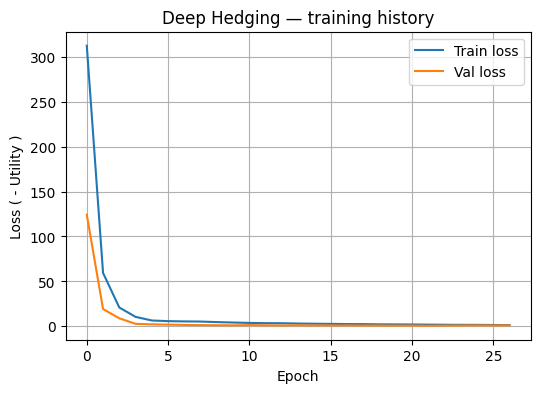

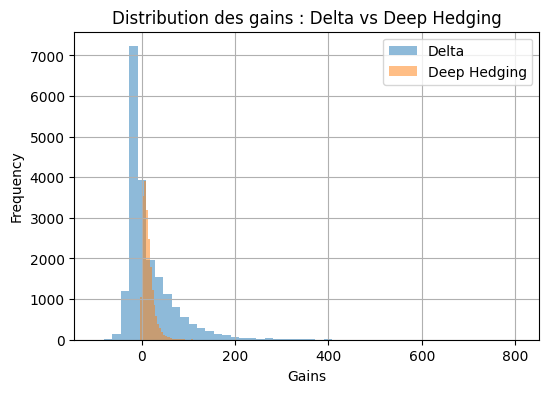

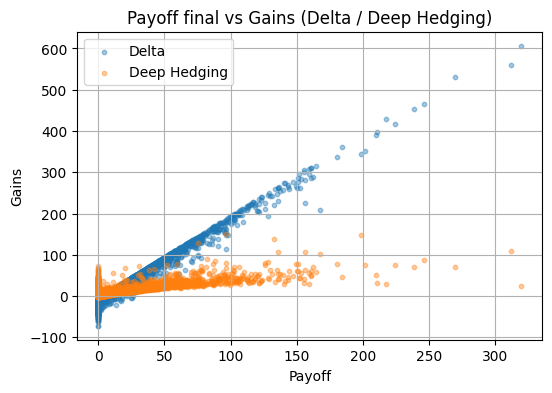

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history["train_loss"], label="Train loss")
    plt.plot(history["val_loss"], label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss ( - Utility )")
    plt.legend()
    plt.title("Deep Hedging — training history")
    plt.grid(True)
    plt.show()

def plot_gains_hist(eval_res, bins=50):
    gains_deep  = eval_res["gains_deep"]
    gains_delta = eval_res["gains_delta"]
    
    plt.figure(figsize=(6,4))
    plt.hist(gains_delta, bins=bins, alpha=0.5, label="Delta")
    plt.hist(gains_deep,  bins=bins, alpha=0.5, label="Deep Hedging")
    plt.xlabel("Gains")
    plt.ylabel("Frequency")
    plt.title("Distribution des gains : Delta vs Deep Hedging")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_payoff_vs_gains(eval_res, n_points=5_000):
    payoff = eval_res["payoff"]
    gains_deep = eval_res["gains_deep"]
    gains_delta = eval_res["gains_delta"]
    
    idx = np.random.choice(len(payoff), size=min(n_points, len(payoff)), replace=False)
    
    plt.figure(figsize=(6,4))
    plt.scatter(payoff[idx], gains_delta[idx], s=10, alpha=0.4, label="Delta")
    plt.scatter(payoff[idx], gains_deep[idx],  s=10, alpha=0.4, label="Deep Hedging")
    plt.xlabel("Payoff")
    plt.ylabel("Gains")
    plt.legend()
    plt.title("Payoff final vs Gains (Delta / Deep Hedging)")
    plt.grid(True)
    plt.show()

# Exemple avec les résultats précédents
plot_training_history(res_train["history"])
plot_gains_hist(eval_res_env, bins=50)
plot_payoff_vs_gains(eval_res_env)



<div style="background:#0f172a;color:#f8fafc;padding:18px 22px;border-radius:12px;font-family:'Inter', Segoe UI, system-ui; line-height:1.6">
  <div style="font-size:18px; font-weight:700; text-decoration:underline; margin-bottom:10px">
    Bloc 12 — Tableau comparatif final : Delta vs Deep Hedging
  </div>

  <p>
    Ce bloc construit un tableau synthétique résumant les performances des deux stratégies :
  </p>

  <ul>
    <li><b>RMSE</b> des gains par rapport au payoff.</li>
    <li><b>Gains moyens</b> et <b>écart-type</b> des gains.</li>
    <li><b>Mean PnL</b> (hors payoff), <b>CVaR</b> et <b>Max Drawdown</b>.</li>
    <li>Coût moyen de transaction pour chaque approche.</li>
  </ul>

  <p>
    Ce tableau fournit une vue d’ensemble chiffrée de l’intérêt du Deep Hedging, en termes de
    réduction du risque extrême et d’efficacité économique, par rapport à la couverture Delta classique.
  </p>
</div>


In [ ]:
import pandas as pd
import numpy as np

def compute_rmse(pred, target):
    """RMSE empirique"""
    return float(np.sqrt(np.mean((pred - target)**2)))

def compute_max_drawdown(series):
    """Max drawdown d'une série de gains ou pnl."""
    series = np.asarray(series, dtype=float)
    cummax = np.maximum.accumulate(series)
    dd = (series - cummax) / cummax
    return float(dd.min())


def build_comparison_table(cfg, eval_res):
    """
    Construit un tableau synthétique comparant :
    - stratégie Delta
    - stratégie Deep Hedging
    """
    
    payoff = eval_res["payoff"]
    
    pnl_delta  = eval_res["gains_delta"] - payoff
    pnl_deep   = eval_res["gains_deep"]  - payoff
    
    gains_delta = eval_res["gains_delta"]
    gains_deep  = eval_res["gains_deep"]
    
    util = MonetaryUtility(kind="cvar", alpha=cfg.training.cvar_alpha)

    # RMSE sur les gains (vs payoff)
    rmse_delta = compute_rmse(gains_delta, payoff)
    rmse_deep  = compute_rmse(gains_deep, payoff)

    # Mean gains
    mean_delta = float(np.mean(gains_delta))
    mean_deep  = float(np.mean(gains_deep))

    # Std gains
    std_delta = float(np.std(gains_delta))
    std_deep  = float(np.std(gains_deep))

    # Mean PnL (hors payoff)
    mean_pnl_delta = float(np.mean(pnl_delta))
    mean_pnl_deep  = float(np.mean(pnl_deep))

    # CVaR (déjà calculé dans eval_res)
    cvar_delta = eval_res["cvar_delta"]
    cvar_deep  = eval_res["cvar_deep"]

    # Max Drawdown
    mdd_delta = compute_max_drawdown(gains_delta)
    mdd_deep  = compute_max_drawdown(gains_deep)

    # Cost moyen
    cost_deep_mean = float(np.mean(eval_res.get("cost_deep", 0)))
    cost_delta_mean = float(np.mean(eval_res.get("cost_delta", 0))) if "cost_delta" in eval_res else np.nan

    # Tableau
    table = pd.DataFrame({
        "Delta Hedge": {
            "RMSE (vs payoff)": rmse_delta,
            "Mean Gains": mean_delta,
            "Std Gains": std_delta,
            "Mean PnL": mean_pnl_delta,
            "CVaR": cvar_delta,
            "Max Drawdown": mdd_delta,
            "Mean Cost": cost_delta_mean,
        },
        "Deep Hedging": {
            "RMSE (vs payoff)": rmse_deep,
            "Mean Gains": mean_deep,
            "Std Gains": std_deep,
            "Mean PnL": mean_pnl_deep,
            "CVaR": cvar_deep,
            "Max Drawdown": mdd_deep,
            "Mean Cost": cost_deep_mean,
        }
    })

    return table.T  # .T pour avoir une ligne par stratégie

# Construction du tableau
comparison_table = build_comparison_table(cfg, eval_res_env)

display(comparison_table)


,RMSE (vs payoff),Mean Gains,Std Gains,Mean PnL,CVaR,Max Drawdown,Mean Cost
Delta Hedge,28.993111,17.319054,55.59964,1.876607,-43.381386,-1.356295,0.053140
Deep Hedging,21.141411,13.990273,12.72652,-1.452172,-0.703340,-1.024034,0.014498


<div style="background:#0f172a;color:#f8fafc;padding:18px 22px;border-radius:12px;font-family:'Inter', Segoe UI, system-ui; line-height:1.6">
  <div style="font-size:18px; font-weight:700; text-decoration:underline; margin-bottom:10px">
    Bloc Final — Analyse du risque : VaR, CVaR, KDE, QQ-Plot & RiskMetrics
  </div>

  <p>
    Ce bloc propose une analyse approfondie de la distribution des gains des deux stratégies
    (Delta Hedging vs Deep Hedging), réalisée à l’aide de la classe <code>RiskMetrics</code>.
    Cette classe centralise l’ensemble des outils statistiques utilisés pour évaluer, visualiser
    et comparer le comportement en risque des stratégies.
  </p>

  <li><b>VaR & CVaR empiriques</b> : calculées directement à partir des échantillons de gains,
      elles permettent de quantifier les pertes extrêmes et de mesurer l’impact de la couverture.</li>

  <li><b>Histogrammes</b> (séparés puis superposés) avec niveaux de VaR tracés : ils offrent une
      première comparaison visuelle de la dispersion des gains entre les deux approches.</li>

  <li><b>Densités KDE</b> : la classe <code>RiskMetrics</code> produit automatiquement une estimation
      lissée de la distribution pour détecter les zones de concentration ou de risque accru.</li>

  <li><b>QQ-Plots</b> : utilisés pour évaluer la déviation des gains par rapport à une loi normale,
      ils mettent en évidence la présence de queues lourdes et la sensibilité aux stress.</li>

  <li><b>Analyse de la queue gauche</b> : zoom spécifique sur les pires scénarios (ex : 30% les plus défavorables),
      permettant d'observer si le Deep Hedging parvient à réduire l’impact des événements extrêmes.</li>

  <p>
    L’utilisation de <code>RiskMetrics</code> apporte une structure plus modulaire et cohérente à l’analyse.
    En centralisant toutes les fonctions de risque, elle permet :
  </p>

  <ul>
    <li>une <b>standardisation</b> de l’ensemble des calculs (VaR, CVaR, KDE, quantiles, QQ-plot) ;</li>
    <li>une <b>réutilisabilité</b> immédiate pour d’autres stratégies (Delta–Gamma, LSTM, Heston, etc.) ;</li>
    <li>une <b>réduction du code redondant</b> et une meilleure lisibilité du notebook ;</li>
    <li>une <b>analyse cohérente</b> quel que soit le modèle de marché utilisé (Black–Scholes, Heston, SABR…).</li>
  </ul>

  <p>
    En résumé, la classe <code>RiskMetrics</code> transforme ce bloc de fin en un véritable module d’analyse de risque,
    robuste et facilement extensible, tout en mettant en évidence de manière visuelle et statistique
    la supériorité du Deep Hedging dans le contrôle des pertes extrêmes.
  </p>
</div>


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, probplot

class RiskMetrics:
    """
    Outil centralisé pour analyser la distribution des gains :
    - VaR, CVaR (empiriques)
    - Histogrammes
    - KDE (densité estimée)
    - QQ-Plot vs loi normale
    - Zoom sur la queue gauche
    """

    def __init__(self, alpha: float = 0.05):
        self.alpha = alpha

    # ---------- VaR / CVaR ----------
    def empirical_var(self, samples: np.ndarray) -> float:
        samples = np.asarray(samples, dtype=float)
        sorted_samples = np.sort(samples)
        n = len(sorted_samples)
        k = max(0, int(self.alpha * n) - 1)
        return float(sorted_samples[k])

    def empirical_cvar(self, samples: np.ndarray) -> float:
        samples = np.asarray(samples, dtype=float)
        sorted_samples = np.sort(samples)
        n = len(sorted_samples)
        k = max(1, int(self.alpha * n))
        tail = sorted_samples[:k]
        return float(tail.mean())

    # ---------- Plots ----------
    def plot_hist_with_var(self, gains: np.ndarray, title: str = ""):
        gains = np.asarray(gains, dtype=float)
        var = self.empirical_var(gains)

        plt.figure(figsize=(7, 5))
        plt.hist(gains, bins=60, alpha=0.8)
        plt.axvline(var, linestyle="--", label=f"VaR {self.alpha:.0%} = {var:.2f}")
        plt.xlabel("Gains")
        plt.ylabel("Fréquence")
        plt.title(title or f"Distribution des gains (VaR {self.alpha:.0%})")
        plt.grid(True, alpha=0.4)
        plt.legend()
        plt.show()

    def plot_overlap_with_var(self, gains_a, gains_b, label_a="Delta", label_b="Deep"):
        gains_a = np.asarray(gains_a, dtype=float)
        gains_b = np.asarray(gains_b, dtype=float)

        var_a = self.empirical_var(gains_a)
        var_b = self.empirical_var(gains_b)

        plt.figure(figsize=(7, 5))
        plt.hist(gains_a, bins=60, alpha=0.5, label=label_a, density=True)
        plt.hist(gains_b, bins=60, alpha=0.5, label=label_b, density=True)
        plt.axvline(var_a, linestyle="--", label=f"VaR {label_a} {self.alpha:.0%} = {var_a:.2f}")
        plt.axvline(var_b, linestyle="--", label=f"VaR {label_b} {self.alpha:.0%} = {var_b:.2f}")
        plt.xlabel("Gains")
        plt.ylabel("Densité (approx.)")
        plt.title("Distribution des gains — comparaison")
        plt.grid(True, alpha=0.4)
        plt.legend()
        plt.show()

    def plot_kde(self, gains_a, gains_b, label_a="Delta", label_b="Deep"):
        gains_a = np.asarray(gains_a, dtype=float)
        gains_b = np.asarray(gains_b, dtype=float)

        all_gains = np.concatenate([gains_a, gains_b])
        x_min, x_max = np.percentile(all_gains, [0.5, 99.5])
        x_grid = np.linspace(x_min, x_max, 400)

        kde_a = gaussian_kde(gains_a)
        kde_b = gaussian_kde(gains_b)

        plt.figure(figsize=(7, 5))
        plt.plot(x_grid, kde_a(x_grid), label=f"{label_a} (KDE)")
        plt.plot(x_grid, kde_b(x_grid), label=f"{label_b} (KDE)")
        plt.xlabel("Gains")
        plt.ylabel("Densité")
        plt.title("Densité estimée (KDE)")
        plt.grid(True, alpha=0.4)
        plt.legend()
        plt.show()

    def plot_qq(self, gains, title: str = "QQ-plot vs Normal"):
        gains = np.asarray(gains, dtype=float)
        plt.figure(figsize=(6, 5))
        probplot(gains, dist="norm", plot=plt.gca())
        plt.title(title)
        plt.grid(True, alpha=0.4)
        plt.show()

    def plot_left_tail(self, gains_a, gains_b, label_a="Delta", label_b="Deep", q_tail=0.30):
        gains_a = np.asarray(gains_a, dtype=float)
        gains_b = np.asarray(gains_b, dtype=float)

        cut_a = np.quantile(gains_a, q_tail)
        cut_b = np.quantile(gains_b, q_tail)

        var_a = self.empirical_var(gains_a)
        var_b = self.empirical_var(gains_b)

        plt.figure(figsize=(7, 5))
        plt.hist(gains_a[gains_a <= cut_a], bins=40, alpha=0.6, label=label_a)
        plt.hist(gains_b[gains_b <= cut_b], bins=40, alpha=0.6, label=label_b)
        plt.axvline(var_a, linestyle="--", label=f"VaR {label_a} {self.alpha:.0%}")
        plt.axvline(var_b, linestyle="--", label=f"VaR {label_b} {self.alpha:.0%}")
        plt.xlabel("Gains (zone pertes)")
        plt.ylabel("Fréquence")
        plt.title(f"Queue gauche (≈ {int(q_tail*100)}% pires scénarios)")
        plt.grid(True, alpha=0.4)
        plt.legend()
        plt.show()




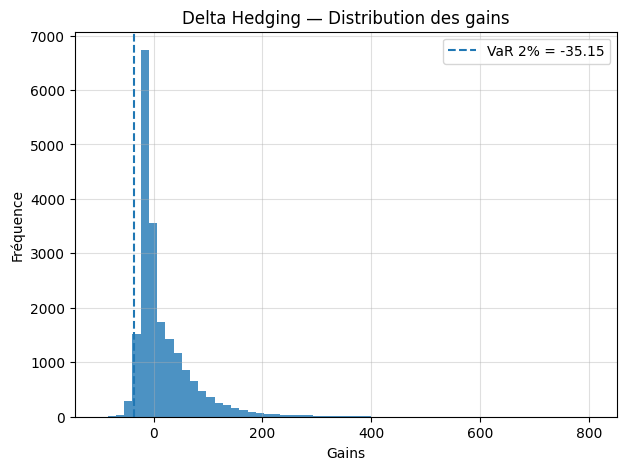

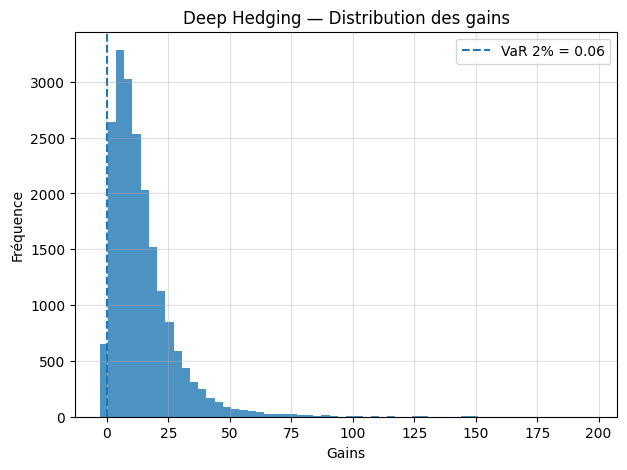

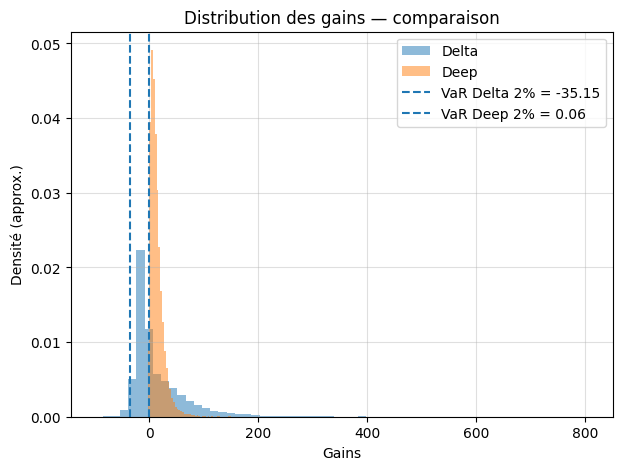

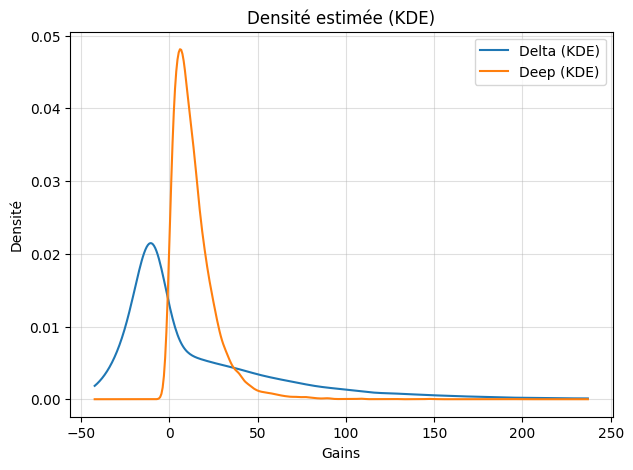

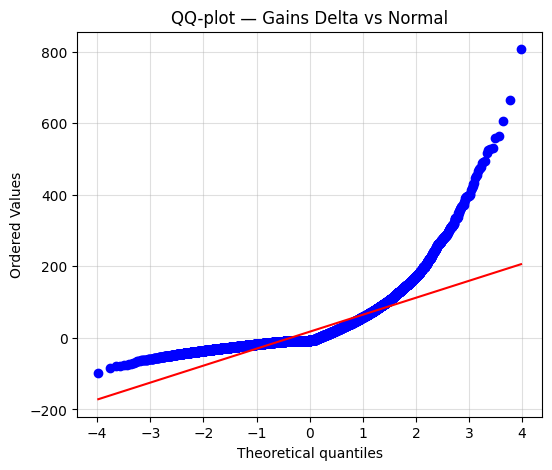

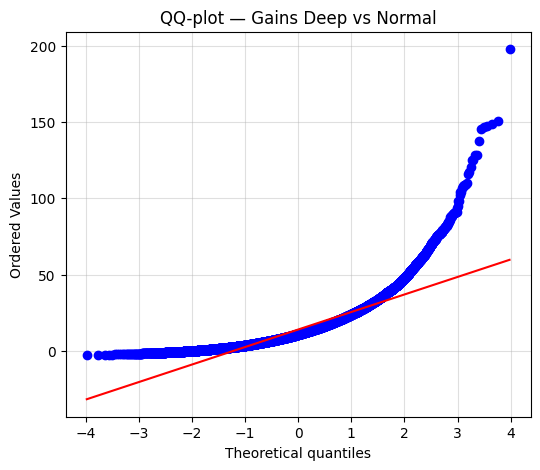

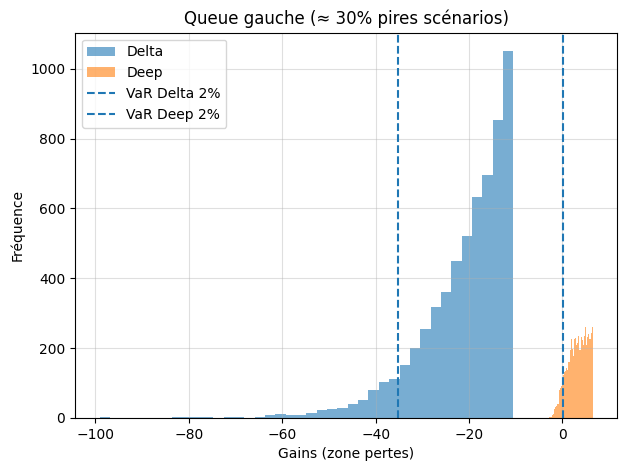

In [ ]:
gains_delta = eval_res_env["gains_delta"]
gains_deep  = eval_res_env["gains_deep"]

rm = RiskMetrics(alpha=cfg.training.cvar_alpha)

# Histogrammes simples avec VaR
rm.plot_hist_with_var(gains_delta, title="Delta Hedging — Distribution des gains")
rm.plot_hist_with_var(gains_deep,  title="Deep Hedging — Distribution des gains")

# Overlap Delta vs Deep
rm.plot_overlap_with_var(gains_delta, gains_deep, label_a="Delta", label_b="Deep")

# KDEs
rm.plot_kde(gains_delta, gains_deep, label_a="Delta", label_b="Deep")

# QQ-plots séparés
rm.plot_qq(gains_delta, title="QQ-plot — Gains Delta vs Normal")
rm.plot_qq(gains_deep,  title="QQ-plot — Gains Deep vs Normal")

# Zoom sur la queue gauche
rm.plot_left_tail(gains_delta, gains_deep, label_a="Delta", label_b="Deep", q_tail=0.30)


<div style="background:#0f172a;color:#f8fafc;padding:18px 22px;border-radius:12px;font-family:'Inter', Segoe UI, system-ui; line-height:1.6">

  <div style="font-size:18px; font-weight:700; text-decoration:underline; margin-bottom:10px">
    Bloc X — Expériences BS→BS et BS→Merton : cohérence de modèle et risque de modèle
  </div>

  <p>
    Dans cette partie, j’utilise le même modèle de <b>Deep Hedging</b> entraîné dans un monde
    de type <b>Black–Scholes pur</b> (sans sauts), puis je l’évalue dans deux environnements différents :
  </p>

  <ul>
    <li><b>BS → BS</b> : entraînement et test dans un monde cohérent de Black–Scholes.</li>
    <li><b>BS → Merton</b> : entraînement sous Black–Scholes, test dans un monde de type Merton avec sauts.</li>
  </ul>

  <h3 style="margin-top:16px;font-size:16px;font-weight:700;">1. Entraînement sous Black–Scholes pur (BS)</h3>

  <p>
    Je définis d’abord une configuration spécifique <code>cfg_bs</code> en imposant <code>use_jumps = False</code>.
    De cette façon :
  </p>

  <ul>
    <li>Les trajectoires d’entraînement sont simulées avec la classe <code>SimpleWorldBS</code>, c’est-à-dire un processus log-normal sous Black–Scholes.</li>
    <li>La politique neuronale <code>PolicyMLP</code> est entraînée sur ces trajectoires en minimisant une
        <b>loss de type CVaR</b> via la classe <code>MonetaryUtility(kind="cvar")</code>.</li>
    <li>On obtient ainsi une stratégie de Deep Hedging calibrée dans un cadre “idéal” BS (diffusion continue, pas de sauts).</li>
  </ul>

  <p>
    Cet entraînement sert de <b>référence</b> : il correspond au cas où le modèle de marché utilisé
    pour le hedging est cohérent avec la dynamique supposée du sous-jacent.
  </p>

  <h3 style="margin-top:16px;font-size:16px;font-weight:700;">2. Expérience BS → BS : cohérence modèle–marché</h3>

  <p>
    Dans un deuxième temps, j’évalue cette même politique Deep Hedging dans un monde de test
    également de type Black–Scholes (<code>SimpleWorldBS</code>) grâce à une fonction d’évaluation générique.
    Cette expérience permet de :
  </p>

  <ul>
    <li>Vérifier que le réseau reproduit correctement un comportement de couverture raisonnable dans le cadre où le modèle est bien spécifié.</li>
    <li>Comparer de manière homogène :
      <ul>
        <li>la stratégie <b>Delta analytique Black–Scholes</b> (<code>DeltaBSPolicy</code>),</li>
        <li>la stratégie de <b>Deep Hedging</b> entraînée sous BS.</li>
      </ul>
    </li>
    <li>Analyser les métriques de risque (RMSE vs payoff, Mean Gains, Std, CVaR, Max Drawdown, coûts moyens)
        à partir du tableau de comparaison et des histogrammes de gains.</li>
  </ul>

  <p>
    Cette étape fournit un <b>benchmark “idéal”</b> : on voit dans quelle mesure le Deep Hedging peut
    améliorer (ou non) la couverture par rapport au Delta dans un monde parfaitement conforme au modèle.
  </p>

  <h3 style="margin-top:16px;font-size:16px;font-weight:700;">3. Expérience BS → Merton : mise en évidence du risque de modèle</h3>

  <p>
    Ensuite, je réutilise exactement la même politique entraînée sous BS, mais je l’évalue
    dans un monde de type <b>Merton</b> avec sauts (<code>SimpleWorldMerton</code>), en conservant
    le même environnement de Deep Hedging (mêmes coûts de transaction, même définition des gains).
    L’idée est de simuler un <b>risque de modèle</b> :
  </p>

  <ul>
    <li>La stratégie a été calibrée sous l’hypothèse d’un marché “lisse” (diffusion continue),</li>
    <li>mais elle est testée dans un marché avec <b>jumps</b> qui violents l’hypothèse de Black–Scholes.</li>
  </ul>

  <p>
    Concrètement, je compare :
  </p>

  <ul>
    <li>le <b>Delta Black–Scholes</b> appliqué dans un monde Merton (Delta mal spécifié),</li>
    <li>la politique de <b>Deep Hedging entraînée sous BS</b> puis testée dans ce même monde avec sauts.</li>
  </ul>

  <p>
    Les tableaux de synthèse et les graphes (histogrammes, VaR/CVaR, QQ-plots, analyse de la queue gauche)
    permettent de voir comment ces deux stratégies réagissent face aux événements extrêmes : 
    amplification de la volatilité des gains, détérioration de la CVaR, augmentation du drawdown, etc.
  </p>

  <h3 style="margin-top:16px;font-size:16px;font-weight:700;">4. Intérêt de cette double expérience</h3>

  <p>
    Ces deux expériences complémentaires ont un rôle précis :
  </p>

  <ul>
    <li><b>BS → BS</b> montre le comportement du Deep Hedging dans un cadre “bien spécifié”
        et sert de test de cohérence du modèle.</li>
    <li><b>BS → Merton</b> met en évidence la <b>sensibilité de la stratégie au risque de modèle</b> :
        on mesure l’impact de sauts non pris en compte à l’entraînement sur la distribution des gains
        et sur les métriques de risque (en particulier dans la queue gauche).</li>
  </ul>

  <p>
    Cette approche permet d’illustrer de manière quantitative que, même si le Deep Hedging peut
    surpasser le Delta dans un monde bien calibré, la qualité de la stratégie reste fortement
    dépendante des hypothèses de modèle utilisées pendant l’entraînement.
  </p>

</div>


In [ ]:
# ============================================================
# 🔹 Bloc A — Config "BS" (training sans sauts)
# ============================================================

from dataclasses import replace

# On part de la config globale cfg déjà définie plus haut
# On force juste use_jumps = False pour que generate_datasets
# utilise SimpleWorldBS (cf. generate_datasets).

cfg_bs = DeepHedgingConfig(
    market=replace(cfg.market, use_jumps=False),
    training=cfg.training,
    device=cfg.device,
    dtype=cfg.dtype,
)

print("Config BS : use_jumps =", cfg_bs.market.use_jumps)


Config BS : use_jumps = False


[Epoch 1/50] train_loss=34.6497 | val_loss=15.2446 | no_improve=0/5
[Epoch 5/50] train_loss=2.5965 | val_loss=0.7490 | no_improve=1/5
[Epoch 10/50] train_loss=1.0491 | val_loss=0.2613 | no_improve=0/5
[Epoch 15/50] train_loss=0.4318 | val_loss=-0.0693 | no_improve=2/5
[Epoch 20/50] train_loss=0.0061 | val_loss=-0.3562 | no_improve=3/5
[Epoch 25/50] train_loss=-0.2376 | val_loss=-0.3611 | no_improve=3/5
⏹️ Early stopping déclenché à l'epoch 27 (meilleure val_loss = -0.6971)
Training BS terminé.


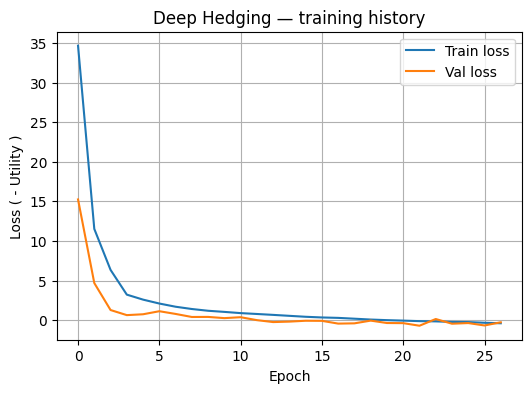

In [ ]:
# ============================================================
# 🔹 Bloc B — Training Deep Hedging sous Black–Scholes (BS)
# ============================================================

policy_bs = PolicyMLP(d_in=2, d_hidden=32, depth=2, dropout=0.1)

res_train_bs = train_deep_hedging(
    cfg_bs,
    policy_bs,
    utility=MonetaryUtility(kind="cvar", alpha=cfg_bs.training.cvar_alpha),
    patience=5,
    min_delta=1e-3,
)

print("Training BS terminé.")
plot_training_history(res_train_bs["history"])


In [ ]:
# ============================================================
# 🔹 Bloc C — Évaluation générique avec choix du monde (BS ou Merton)
# ============================================================

def evaluate_strategies_env_world(cfg: DeepHedgingConfig,
                                  policy_trained: nn.Module,
                                  world_class,
                                  n_paths_eval: int = 20_000,
                                  seed_eval: int = None):

    if seed_eval is None:
        seed_eval = cfg.random.seed_eval_merton  # ou un autre selon ton scénario
    """
    Compare :
    - stratégie Deep Hedging (policy_trained)
    - stratégie Delta Black–Scholes analytique (DeltaBSPolicy)

    dans un monde donné : world_class ∈ {SimpleWorldBS, SimpleWorldMerton}.
    """
    # 1) Génération d'un dataset de test dans le monde choisi
    world = world_class(cfg.market)
    data = world.simulate_paths(n_paths_eval, seed=seed_eval)

    S_np = data["S"]       # (N, T+1)
    payoff_np = data["payoff"]  # (N,)

    # Conversion en torch
    S = torch.tensor(S_np, dtype=cfg.dtype, device=cfg.device)
    payoff = torch.tensor(payoff_np, dtype=cfg.dtype, device=cfg.device)

    # 2) Environnement
    env = DeepHedgingEnv(cfg)

    # 3) Deep Hedging policy
    policy_trained = policy_trained.to(cfg.device)
    policy_trained.eval()
    with torch.no_grad():
        out_deep = env.rollout(policy_trained, S, payoff)
        gains_deep = out_deep["gains"].detach().cpu()
        pnl_deep   = out_deep["pnl"].detach().cpu()
        cost_deep  = out_deep["cost"].detach().cpu()

    # 4) Delta Black–Scholes (policy analytique)
    delta_policy = DeltaBSPolicy(cfg.market, device=cfg.device, dtype=cfg.dtype).to(cfg.device)
    delta_policy.eval()
    with torch.no_grad():
        out_delta = env.rollout(delta_policy, S, payoff)
        gains_delta = out_delta["gains"].detach().cpu()
        pnl_delta   = out_delta["pnl"].detach().cpu()
        cost_delta  = out_delta["cost"].detach().cpu()

    # 5) Mesures de risque (CVaR, std, etc.)
    util = MonetaryUtility(kind="cvar", alpha=cfg.training.cvar_alpha)
    cvar_delta = util.utility(gains_delta).item()
    cvar_deep  = util.utility(gains_deep).item()

    std_delta = gains_delta.std().item()
    std_deep  = gains_deep.std().item()

    results = {
        "gains_deep":  gains_deep.numpy(),
        "gains_delta": gains_delta.numpy(),
        "pnl_deep":    pnl_deep.numpy(),
        "pnl_delta":   pnl_delta.numpy(),
        "cost_deep":   cost_deep.numpy(),
        "cost_delta":  cost_delta.numpy(),
        "payoff":      payoff_np,
        "cvar_delta":  cvar_delta,
        "cvar_deep":   cvar_deep,
        "std_delta":   std_delta,
        "std_deep":    std_deep,
    }
    return results


=== BS → BS ===
CVaR Deep  : 0.7185252904891968
CVaR Delta : -10.718341827392578
Std Deep   : 4.573994159698486
Std Delta  : 30.160995483398438


,RMSE (vs payoff),Mean Gains,Std Gains,Mean PnL,CVaR,Max Drawdown,Mean Cost
Delta Hedge,15.453569,11.852737,30.160242,1.959747,-10.718342,-1.084631,0.057240
Deep Hedging,14.489338,7.989356,4.573880,-1.903634,0.718525,-1.145336,0.019596


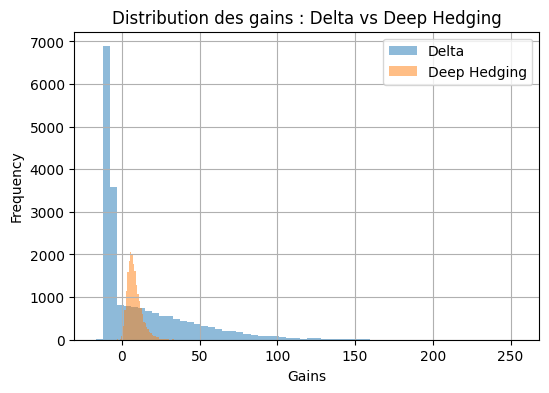

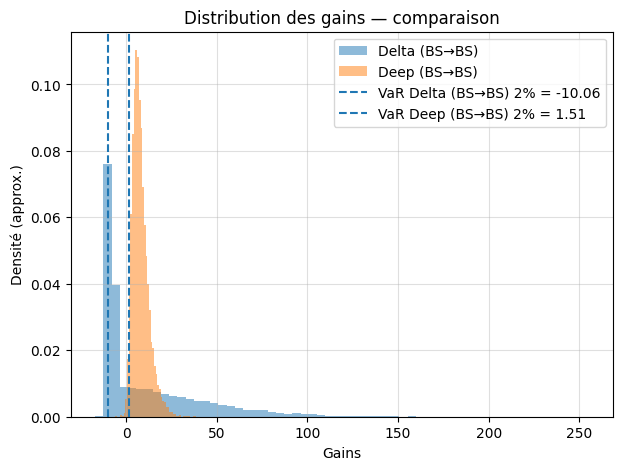

In [ ]:
# ============================================================
# 🔹 Bloc D1 — Expérience 1 : Train BS, Test BS
# ============================================================

# BS → BS
eval_bs_bs = evaluate_strategies_env_world(
    cfg_bs,
    res_train_bs["policy"],
    world_class=SimpleWorldBS,
    n_paths_eval=20_000,
    seed_eval=cfg_bs.random.seed_eval_bs,
)


print("=== BS → BS ===")
print("CVaR Deep  :", eval_bs_bs["cvar_deep"])
print("CVaR Delta :", eval_bs_bs["cvar_delta"])
print("Std Deep   :", eval_bs_bs["std_deep"])
print("Std Delta  :", eval_bs_bs["std_delta"])

table_bs_bs = build_comparison_table(cfg_bs, eval_bs_bs)
display(table_bs_bs)

# Visuels (optionnels)
plot_gains_hist(eval_bs_bs, bins=60)
rm = RiskMetrics(alpha=cfg_bs.training.cvar_alpha)
rm.plot_overlap_with_var(eval_bs_bs["gains_delta"], eval_bs_bs["gains_deep"],
                         label_a="Delta (BS→BS)", label_b="Deep (BS→BS)")


=== BS → Merton ===
CVaR Deep  : -4.298620700836182
CVaR Delta : -43.381385803222656
Std Deep   : 13.957571983337402
Std Delta  : 55.60103225708008


,RMSE (vs payoff),Mean Gains,Std Gains,Mean PnL,CVaR,Max Drawdown,Mean Cost
Delta Hedge,28.993111,17.319054,55.599640,1.876607,-43.381386,-1.356295,0.053140
Deep Hedging,25.635764,13.669364,13.957223,-1.773082,-4.298621,-1.839177,0.021261


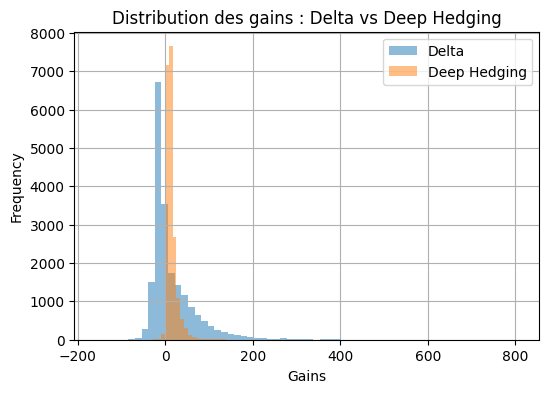

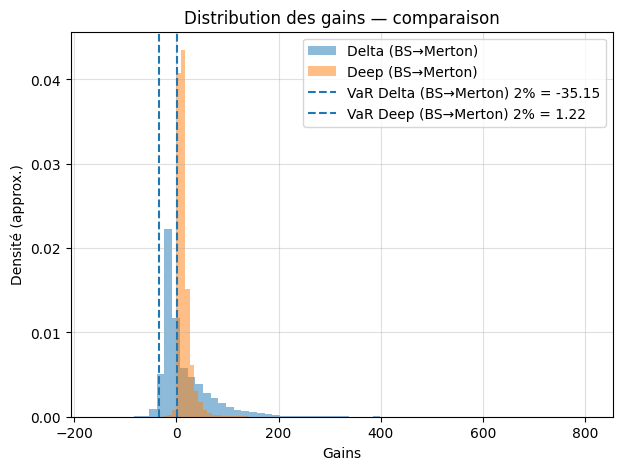

In [ ]:
# ============================================================
# 🔹 Bloc D2 — Expérience 2 : Train BS, Test Merton
# ============================================================

# BS → Merton
eval_bs_merton = evaluate_strategies_env_world(
    cfg_bs,
    res_train_bs["policy"],
    world_class=SimpleWorldMerton,
    n_paths_eval=20_000,
    seed_eval=cfg_bs.random.seed_eval_bs_merton,
)

print("=== BS → Merton ===")
print("CVaR Deep  :", eval_bs_merton["cvar_deep"])
print("CVaR Delta :", eval_bs_merton["cvar_delta"])
print("Std Deep   :", eval_bs_merton["std_deep"])
print("Std Delta  :", eval_bs_merton["std_delta"])

table_bs_merton = build_comparison_table(cfg_bs, eval_bs_merton)
display(table_bs_merton)

# Visuels (optionnels)
plot_gains_hist(eval_bs_merton, bins=60)
rm = RiskMetrics(alpha=cfg_bs.training.cvar_alpha)
rm.plot_overlap_with_var(eval_bs_merton["gains_delta"], eval_bs_merton["gains_deep"],
                         label_a="Delta (BS→Merton)", label_b="Deep (BS→Merton)")


<div style="background:#0f172a;color:#f8fafc;padding:18px 22px;border-radius:12px;font-family:'Inter', Segoe UI, system-ui; line-height:1.6">

  <div style="font-size:18px; font-weight:700; text-decoration:underline; margin-bottom:10px">
    Conclusion – Deep Hedging, cohérence de modèle et risque de modèle
  </div>

  <p>
    Les expériences menées mettent en évidence deux régimes distincts :
    un cas <b>cohérent</b> (BS→BS) et un cas de <b>risque de modèle</b> (BS→Merton).
  </p>

  <ul>
    <li>
      <b>BS → BS (modèle bien spécifié)</b> :  
      lorsque le modèle utilisé à l’entraînement correspond au monde de marché,
      la stratégie de <b>Deep Hedging</b> surpasse clairement le <b>Delta Black–Scholes</b>.  
      On observe :
      <ul>
        <li>une <b>volatilité des gains</b> fortement réduite,</li>
        <li>une <b>CVaR significativement améliorée</b> (queue gauche mieux contrôlée),</li>
        <li>des <b>coûts de transaction plus faibles</b>.</li>
      </ul>
    </li>

  <li style="margin-top:6px;">
      <b>BS → Merton (risque de modèle)</b> :  
      en présence de sauts non pris en compte à l’entraînement, les deux stratégies se dégradent,
      mais pas dans les mêmes proportions. Le <b>Delta BS</b> devient très sensible aux discontinuités
      (CVaR fortement négative, forte dispersion), tandis que le <b>Deep Hedging</b> conserve :
      <ul>
        <li>une <b>CVaR nettement moins dégradée</b>,</li>
        <li>une <b>dispersion des gains plus contenue</b>,</li>
        <li>une <b>exposition plus limitée aux scénarios extrêmes</b>.</li>
      </ul>
    </li>
  </ul>

  <p style="margin-top:8px;">
    Au total, ces résultats montrent que :
  </p>

  <ul>
    <li>
      dans un monde bien spécifié, le <b>Deep Hedging domine le Delta</b> sur toutes les métriques de risque (variance, CVaR, coûts) ;
    </li>
    <li>
      sous risque de modèle, le Deep Hedging reste <b>plus robuste</b>, grâce à
      une optimisation directe d’un critère de type <b>CVaR</b> qui pénalise explicitement la queue gauche.
    </li>
  </ul>

  <p style="margin-top:8px;">
    Le Deep Hedging apparaît ainsi comme une approche de couverture <b>flexible</b> et
    <b>adaptative</b>, mieux adaptée que le Delta analytique aux environnements de marché
    soumis à des non-linéarités et à des événements extrêmes.
  </p>

</div>


In [ ]:
# ============================================================
# Bloc — Tableau de synthèse coloré
# Scénarios : Merton→Merton, BS→BS, BS→Merton
# ============================================================

import pandas as pd
import numpy as np

# 0) Rappels des objets déjà existants dans ton notebook :
#    - cfg                : config Merton (use_jumps=True)
#    - eval_res_env       : résultats Merton→Merton (ton premier modèle)
#    - cfg_bs             : config BS (use_jumps=False)
#    - eval_bs_bs         : résultats BS→BS
#    - eval_bs_merton     : résultats BS→Merton
#    - build_comparison_table(cfg, eval_res)

# 1) Construire les tableaux pour chaque scénario

# BS → BS
table_bs_bs = build_comparison_table(cfg_bs, eval_bs_bs).copy()
table_bs_bs.insert(0, "Scenario", "BS → BS")

# BS → Merton
table_bs_merton = build_comparison_table(cfg_bs, eval_bs_merton).copy()
table_bs_merton.insert(0, "Scenario", "BS → Merton")

# Merton → Merton (ton modèle de base)
eval_merton_merton = eval_res_env  # déjà calculé plus haut
table_merton_merton = build_comparison_table(cfg, eval_merton_merton).copy()
table_merton_merton.insert(0, "Scenario", "Merton → Merton")

# 2) Concaténer tous les scénarios

summary_df = pd.concat(
    [table_bs_bs, table_bs_merton, table_merton_merton],
    axis=0
)

# Index multi (Scenario, Strategy)
summary_df = summary_df.reset_index().rename(columns={"index": "Strategy"})
summary_df = summary_df.set_index(["Scenario", "Strategy"])

# 3) Configuration des métriques et du sens "mieux / moins bien"

metrics_cfg = {
    "RMSE (vs payoff)": {"higher_is_better": False},
    "Mean Gains":       {"higher_is_better": True},
    "Std Gains":        {"higher_is_better": False},
    "Mean PnL":         {"higher_is_better": True},
    "CVaR":             {"higher_is_better": True},   # CVaR sur les gains
    "Max Drawdown":     {"higher_is_better": False},
    "Mean Cost":        {"higher_is_better": False},
}

metric_cols = [c for c in summary_df.columns if c in metrics_cfg]
summary_metrics = summary_df[metric_cols].astype(float)


def _color_cell(val, vmin, vmax, higher_is_better):
    """Retourne un style CSS (vert / orange / rouge) pour une cellule."""
    if np.isnan(val):
        return ""

    # Normalisation 0–1
    if vmax == vmin:
        ratio = 0.5
    else:
        ratio = (val - vmin) / (vmax - vmin)

    # Si "plus petit = mieux", on inverse
    if not higher_is_better:
        ratio = 1.0 - ratio

    # Découpage en 3 zones
    if ratio <= 1/3:
        color = "#ff4d4d"   # rouge
    elif ratio <= 2/3:
        color = "#ffa500"   # orange
    else:
        color = "#4caf50"   # vert

    return f"background-color: {color}; color: white;"


def traffic_light_style(df):
    """Applique le code couleur colonne par colonne."""
    styles = pd.DataFrame("", index=df.index, columns=df.columns)

    for col in df.columns:
        cfg_col = metrics_cfg.get(col)
        if cfg_col is None:
            continue

        col_values = df[col].astype(float)
        vmin, vmax = col_values.min(), col_values.max()

        for idx, val in col_values.items():
            styles.loc[idx, col] = _color_cell(
                val,
                vmin=vmin,
                vmax=vmax,
                higher_is_better=cfg_col["higher_is_better"]
            )

    return styles


# 4) Styler + affichage

styled_summary = (
    summary_metrics
    .style
    .apply(traffic_light_style, axis=None)
    .format("{:.3f}")
)

display(styled_summary)
